## Problem 1

One input parameter I had an idea of what it might be but not an exact knowledge of is the "RGB Wind Scaling Factor". I assumed this would have something to do with stellar wind of stars on the red giant branch, but I wasn't sure why this parameter would be used and what exactly about the wind it specified. After looking at the MESA website which explains the parameters (http://user.astro.wisc.edu/~townsend/static.php?ref=mesa-web-input), this is a factor which scales the mass loss rate from wind of stars on the red giant branch. To be exact, this number is multiplied into the mass loss rate derived from a 'prescription' which models the stellar winds. The 'Red Giant Branch Wind Prescription' parameter allows you the specify which model to use, and they are derived from a variety of works in the literature which model winds from RGB stars.


I misread the prompt at first and thought it was asking for an output parameter, not an input. I just kept my writing on that below since I didn't want to waste that work.

One parameter I didn't know the interpretation of is the compactness parameter $\xi$. After reading through some papers (https://iopscience.iop.org/article/10.1088/0004-637X/730/2/70/pdf, https://iopscience.iop.org/article/10.1088/0004-637X/783/1/10, https://arxiv.org/abs/1807.09071, etc.) it seems like there may be a few cases where this parameter is used, but in general they all have the same definition. The 'compactness' of an object is the ratio of its mass to its radius. In the first paper labelled, they define the compactness parameter in the context of a star that's beginning to collapse. Specifically, they argue that the compactness parameter at the time when the infalling material of a collapsing star 'bounces' off the core determines whether or not a supernova will occur. The same case is taken in the second paper, while the third only looks at the compactness of stellar remnants (specifically neutron stars). 

## Problem 2
### a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
import astropy.constants as c
import mesa_web

In [2]:
history_fname = 'mesa/MESA-Web_Job_09112317926/trimmed_history.data'
data_dict = mesa_web.read_history(history_fname)

In [3]:
age = np.log10(data_dict['star_age'])
star_mass = data_dict['star_mass'] * u.Msun
R = 10**data_dict['log_R'] * u.Rsun
Volume = 4/3 * np.pi * R**3
rho = star_mass / Volume # Average density of the whole star

P_analytic = c.G * star_mass * rho / R # Estimate for central pressure from example 10.1.1
P_analytic = P_analytic.to(u.dyne/u.cm**2) # Analytic pressure estimate
P_central = data_dict['log_center_P'] * (u.dyne/u.cm**2) # Simulated central pressure

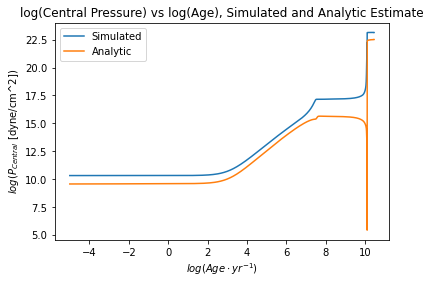

In [4]:
plt.plot(age, P_central, label='Simulated')
plt.plot(age, np.log10(P_analytic.value), label='Analytic')

plt.title(r'log(Central Pressure) vs log(Age), Simulated and Analytic Estimate')
plt.xlabel(r' $ log(Age \cdot yr^{-1}) $ ')
plt.ylabel(r' $ log(P_{Central} $ [dyne/cm^2] $ ) $ ')
plt.legend();

The approximation seems to be best before ~10^6 . My guess is that this is because before the star starts fusion, the density of the star is a lot more uniformly distributed than it is after ~10^8 - 10^9 Gyr. The extreme density of the core that causes fusion to occur is also responsible for the failure of the approximation of average density used in the analytic estimate, so it fails. This also explains why the estimate is actually fairly good again for the stellar remnant, since the mass also might be more uniformly distributed now that fusion has ceased in the leftover core.

The analytic estimate seems worst a little above 10^10 yr, which corresponds to the period at which the star dies. This might be because the density and radius of the star both vary wildly during the extremely short window of collapse, which causes our estimate to go haywire while the physical pressure should vary smoothly from its initial to final state.

### b)
To get the power-law approximated total luminosities for each process, first we need to estimate the energy generation rate. We then multiply by the total amount of mass available for fusion to get a luminosity.

In [5]:
rho_center = 10**data_dict['log_center_Rho'] * u.g/u.cm**3 # central density
lum_total = 10**data_dict['log_L'] * u.Lsun
lum_pp = 10**data_dict['pp'] * u.Lsun
lum_CNO = 10**data_dict['cno'] * u.Lsun

In [6]:
eps_0_pp = 1.08e-12 * u.W*u.m**3/u.kg**2
X = H_frac = data_dict['center_h1']
f_pp = 1 # Assume screening factor of ~1
psi_pp = 1 # Assume branch ratio of ~1
C_pp = 1 # Ignore higher order correction terms
eps_pp = lambda x: eps_0_pp*rho_center*X**2*f_pp*psi_pp*C_pp*x**4 # equation 10.59

In [7]:
eps_0_CNO = 8.24e-31 * u.W*u.m**3/u.kg**2
X_CNO = data_dict['center_c12'] + data_dict['center_n14'] + data_dict['center_o16']
eps_CNO = lambda x: eps_0_CNO*rho_center*X*X_CNO*x**19.9 # equation 10.63

In [8]:
# Estimating the total amount of mass of the star that's actually available for 
# fusion based on numbers from previous homeworks.
fusing_fraction = 0.1
fusing_mass = star_mass * fusing_fraction

In [9]:
T_center = 10**data_dict['log_center_T']
T_6 = T_center / 1e6
lum_pp_power_law = (eps_pp(T_6) * fusing_mass).to(u.Lsun)
lum_CNO_power_law = (eps_CNO(T_6) * fusing_mass).to(u.Lsun)

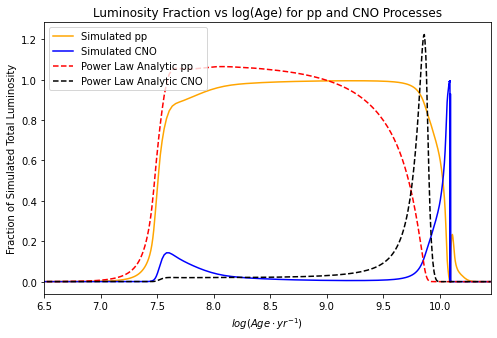

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(age, lum_pp/lum_total, c='orange', label='Simulated pp')
plt.plot(age, lum_CNO/lum_total, c='blue', label='Simulated CNO')
plt.plot(age, lum_pp_power_law/lum_total, c='red', ls='--', label='Power Law Analytic pp')
plt.plot(age, lum_CNO_power_law/lum_total, c='black', ls='--', label='Power Law Analytic CNO')

plt.title(r'Luminosity Fraction vs log(Age) for pp and CNO Processes')
plt.xlim(6.5, 10.45175546)
plt.xlabel(r' $ log(Age \cdot yr^{-1}) $ ')
plt.ylabel(r'Fraction of Simulated Total Luminosity')
plt.legend(loc='upper left');

The power law approximations centered around T = 1.5 * 10^7, as given in the textbook, actually are pretty good estimates for the relative luminosities of the two processes in question. They give the right general shape and magnitude, but are slightly off in certain regions. This is because the power law estimates are extremely temperature dependent, so if the temperature of the system is far away from where the power law forms are centered, they will give a relatively poor approximatinon.

## Problem 3
### a)
We need to figure out a way to plot some physical quantities against eachother to figure out if these stellar models are polytropes. To do this, we can construct a loglog plot of pressure against density. From the polytrope equation we should expect that a polytropic model would be a straight line on this plot.

$ P = K\rho^\gamma \rightarrow log(P) = log(K) + \gamma log(\rho) $

In [11]:
profile_fname = 'mesa/MESA-Web_Job_09112317926/profile300.data'
profile_dict = mesa_web.read_profile(profile_fname)

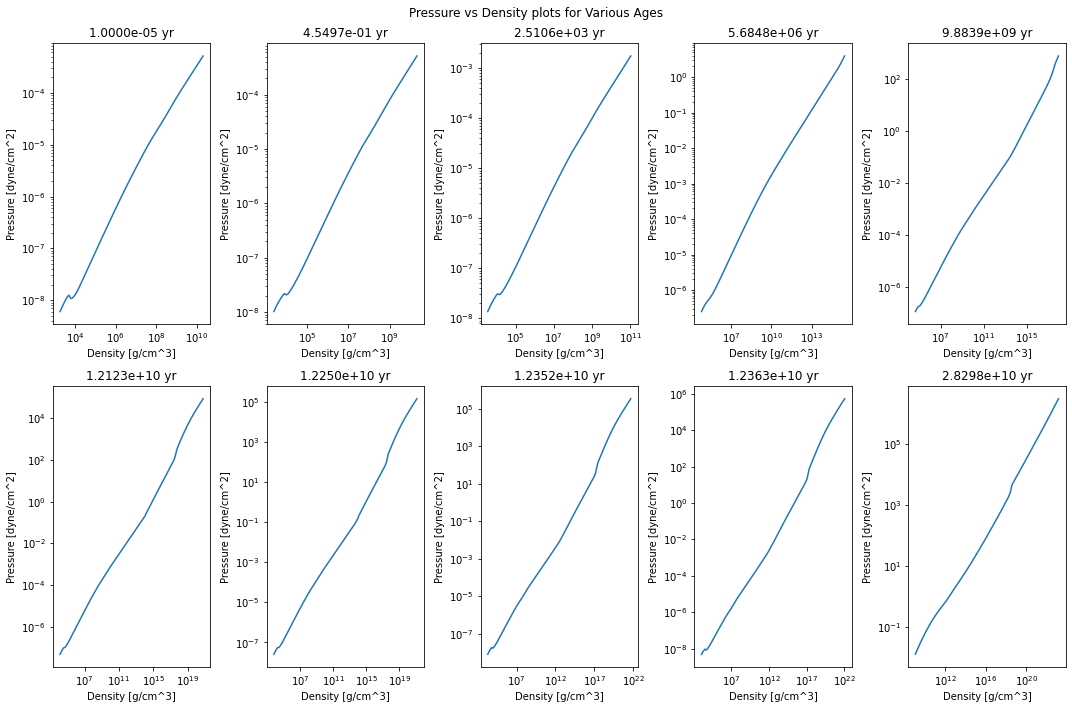

In [12]:
frames = np.array([1, 2, 3, 5, 10, 15, 20, 50, 100, 300]).reshape(2, 5)
plot_nums = frames.shape
fig, ax = plt.subplots(*plot_nums, figsize=(15, 10))

for i, index in enumerate(frames.flatten()):
    profile_fname = f'mesa/MESA-Web_Job_09112317926/profile{index}.data'
    profile_dict = mesa_web.read_profile(profile_fname)
    age = profile_dict['star_age']
    
    P = profile_dict['pressure']
    rho = 10**profile_dict['logRho']
    
    ax[i // 5, i % 5].loglog(P, rho)
    ax[i // 5, i % 5].set_title(f'{age:.4e} yr')
    ax[i // 5, i % 5].set_xlabel('Density [g/cm^3]')
    ax[i // 5, i % 5].set_ylabel('Pressure [dyne/cm^2]')

plt.suptitle('Pressure vs Density plots for Various Ages')
plt.tight_layout()

Indeed, most of these profiles very closely seem to follow straight lines, which means that the stellar model is fairly close to a polytrope at a variety of time and length scales. This is really interesting - polytropic models are quite special in a way, and relatively easy to work with. They don't have that many degrees of freedom, and yet they can still describe a variety of types and ages of stars (protostar, main sequence, red giant, and even stellar remnants).

### b)

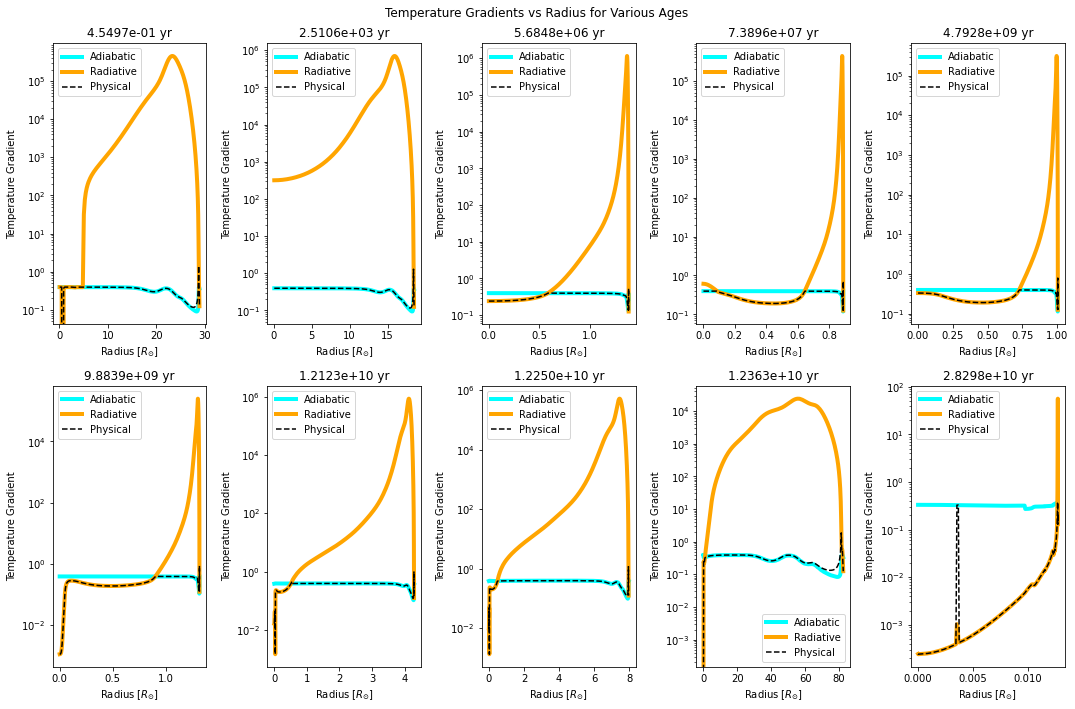

In [13]:
frames = np.array([2, 3, 5, 7, 8, 10, 15, 20, 100, 300]).reshape(2, 5)
plot_nums = frames.shape
fig, ax = plt.subplots(*plot_nums, figsize=(15, 10))

for i, index in enumerate(frames.flatten()):
    profile_fname = f'mesa/MESA-Web_Job_09112317926/profile{index}.data'
    profile_dict = mesa_web.read_profile(profile_fname)
    age = profile_dict['star_age']
    
    r = profile_dict['radius']
    grad_adiabatic = profile_dict['grada']
    grad_radiative = profile_dict['gradr']
    grad_physical = profile_dict['gradT']
 
    ax[i // 5, i % 5].semilogy(r, grad_adiabatic, c='cyan', lw=4, label='Adiabatic')
    ax[i // 5, i % 5].semilogy(r, grad_radiative, c='orange', lw=4, label='Radiative')
    ax[i // 5, i % 5].semilogy(r, grad_physical, c='black', ls='--', label='Physical')
    ax[i // 5, i % 5].set_title(f'{age:.4e} yr') 
    ax[i // 5, i % 5].set_xlabel(r'Radius [ $ R_{\odot} $ ]')
    ax[i // 5, i % 5].set_ylabel('Temperature Gradient')
    ax[i // 5, i % 5].legend()
    
plt.suptitle('Temperature Gradients vs Radius for Various Ages')
plt.tight_layout()

For either radiative transfer or convection to be dominant, the physical temperature gradient must be greater than the required radiative/adiabatic temperature gradient. This means that if the physical gradient is on the same order or greater than the adiabatic gradient, then convection will occur. Similarly, if the physical gradient is greater than the radiative gradient, then radiative transfer will be important. From the plots above, we see that the radiative temperature gradient is much greater than the physical one in many regions, whereas the convective one is on the same order or less than the physical gradient. For example, along the main sequence (the snapshots where age ~ 5-9 Gyr), the central part of the star is dominated by radiative transfer whereas convection takes over closer to the surface as expected. Before fusion properly starts in the earliest snapshots, convection is entirely dominant. In the stellar remnant (last snapshot), convection is unable to occur (presumably because the density is too great) so the star is radiatively supported.

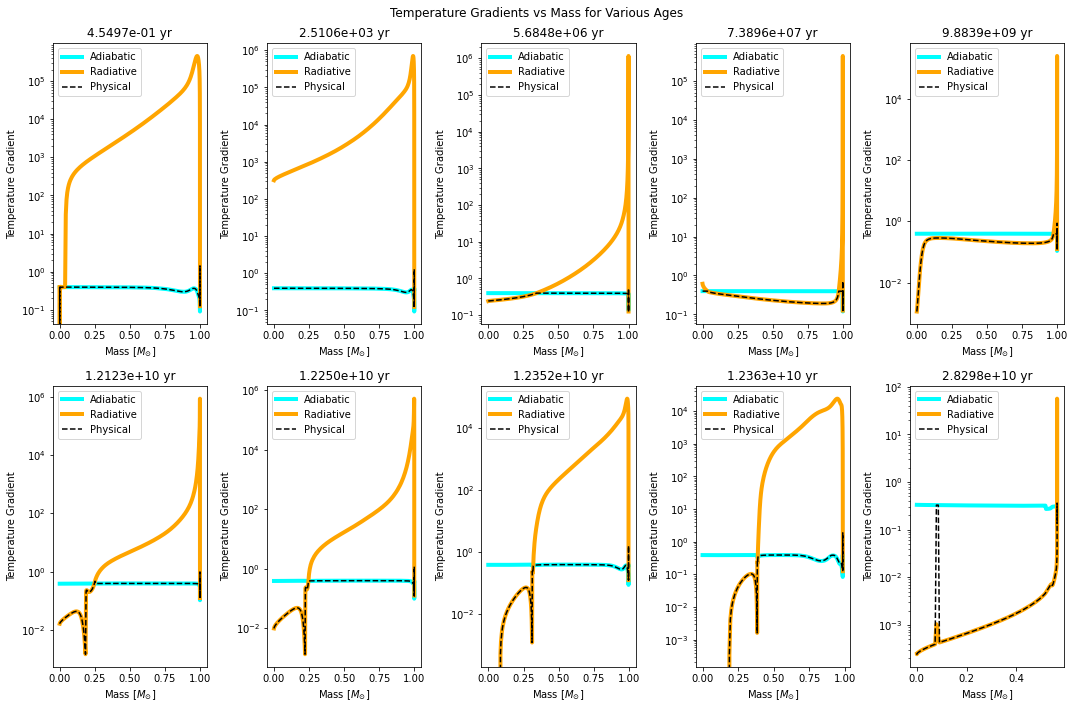

In [14]:
frames = np.array([2, 3, 5, 7, 10, 15, 20, 50, 100, 300]).reshape(2, 5)
plot_nums = frames.shape
fig, ax = plt.subplots(*plot_nums, figsize=(15, 10))

for i, index in enumerate(frames.flatten()):
    profile_fname = f'mesa/MESA-Web_Job_09112317926/profile{index}.data'
    profile_dict = mesa_web.read_profile(profile_fname)
    age = profile_dict['star_age']

    grad_adiabatic = profile_dict['grada']
    grad_radiative = profile_dict['gradr']
    grad_physical = profile_dict['gradT']
    m = profile_dict['mass']

    ax[i // 5, i % 5].semilogy(m, grad_adiabatic, c='cyan', lw=4, label='Adiabatic')
    ax[i // 5, i % 5].semilogy(m, grad_radiative, c='orange', lw=4, label='Radiative')
    ax[i // 5, i % 5].semilogy(m, grad_physical, c='black', ls='--', label='Physical')
    ax[i // 5, i % 5].set_title(f'{age:.4e} yr')  
    ax[i // 5, i % 5].set_xlabel(r'Mass [ $ M_{\odot} $ ]')
    ax[i // 5, i % 5].set_ylabel('Temperature Gradient')
    ax[i // 5, i % 5].legend()
    
plt.suptitle('Temperature Gradients vs Mass for Various Ages')
plt.tight_layout()

The above plots can be interpreted similarly to the plots which are a function of the radius coordinate. We see that for the protostar, most of the enclosed mass is in the convective zone. Once fusion starts, most of the enclosed mass on the main sequence actually transitions to the radiative zone, with a small amount in the convective zone towards the surface. As the star reaches the red giant branch, its convective zone grows to include the majority of the mass content of the star, while the inner region remains firmly radiatively supported. Finally, the stellar remnant is mostly radiatively supported.

## Note: I left units off of the temperature gradient because the MESA documentation did not specify them for some reason. However, they might be something like K/cm.